<a href="https://colab.research.google.com/github/shilpasy/Variant-Prioritization-miniproject-with-AlphaMissense-cBioPortal-and-ESM-models/blob/main/5_Visualize_sign_residues_on_p53_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py3Dmol

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, io, math, json, urllib.request
import pandas as pd
import numpy as np
import py3Dmol
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
CSV_PATH = "/content/drive/MyDrive/AlphaMissense_ex/TP53_ESM2_umap_augmented.csv"   # has Position, WT_AA, Mut_AA, AlphaMissense_Pathogenicity, delta_logit_site
COLOR_BY = "delta_logprob_masked"               # "delta_logit_site" is the unedited one from ESMs (recommended) or "AlphaMissense_Pathogenicity"
LABEL_ALL = False                           # True = label every variant (crowded), False = label TOP_N
TOP_N = 20                                  # used if LABEL_ALL=False
SPHERE_RADIUS = 1.0
OUT_PNG = "TP53_structure_hotspots.png"


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

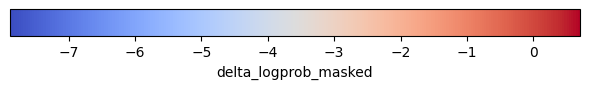

In [ ]:
# AlphaFold TP53 (P04637) full-length model- easier for consistent UniProt numbering than usign actual rcsb pdb file
AF_URL = "https://alphafold.ebi.ac.uk/files/AF-P04637-F1-model_v4.pdb"
AF_PDB = "AF-P04637-F1-model_v4.pdb"

if not os.path.exists(AF_PDB):
    urllib.request.urlretrieve(AF_URL, AF_PDB)
with open(AF_PDB, "r") as f:
    pdb_str = f.read()

df = pd.read_csv(CSV_PATH)

df = df[df["Variant"].ne("WT")].copy() ## # keep only real variants (no WT),we need positions

if "Position" not in df.columns:
    raise ValueError("Position column missing — your CSV must include residue numbers.")
df["Position"] = pd.to_numeric(df["Position"], errors="coerce").astype("Int64")
df = df.dropna(subset=["Position"]).copy()
df["Position"] = df["Position"].astype(int)

# if the delta logit values aren't available then use AM values as default (pathogenicity scores)
if COLOR_BY not in df.columns or df[COLOR_BY].isna().all():
    COLOR_BY = "AlphaMissense_Pathogenicity"
df = df.dropna(subset=[COLOR_BY]).copy()

# build clean label text from and remove .p with replace
def clean_label(row):
    if pd.notna(row.get("WT_AA")) and pd.notna(row.get("Mut_AA")):
        return f"{str(row['WT_AA'])}{int(row['Position'])}{str(row['Mut_AA'])}"
    # fallback
    v = str(row.get("Variant", ""))
    return v.replace("p.","")
df["LabelTxt"] = df.apply(clean_label, axis=1)

# if multiple variants hit the same residue, keep the "strongest" one for labeling
if COLOR_BY == "delta_logprob_masked":
    # use absolute delta for labeling priority
    df["_label_rank"] = df["delta_logprob_masked"].abs()
else:
    df["_label_rank"] = df["AlphaMissense_Pathogenicity"]

# dedupe by position for labels (we still draw spheres for all; we just pick 1 label per residue)
labels_per_pos = (
    df.sort_values("_label_rank", ascending=False)
      .drop_duplicates(subset=["Position"])
)

# ----++++- color map setup (use real matplotlib cmap so the colorbar matches) -----
cmap = mpl.cm.coolwarm if COLOR_BY == "delta_logprob_masked" else mpl.cm.viridis

vals = df[COLOR_BY].astype(float).values
# robust limits so outliers don't blow the scale
vmin, vmax = np.percentile(vals, [1, 99])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# helper: map metric value -> hex color used in py3Dmol
def to_hex_color(value):
    rgba = cmap(norm(float(value)))  # (r,g,b,a) in 0..1
    r, g, b = [int(255*x) for x in rgba[:3]]
    return f"#{r:02x}{g:02x}{b:02x}"

# ----++++- render: solid grey cartoon + colored spheres -----
view = py3Dmol.view(width=1000, height=750)
view.addModel(pdb_str, "pdb")
view.setStyle({"cartoon": {"color": "grey"}})  # no transparency anywhere

# spheres for every variant residue
for _, r in df.iterrows():
    resi = int(r["Position"])
    col = to_hex_color(r[COLOR_BY])
    view.addStyle(
        {"resi": str(resi)},
        {"sphere": {"color": col, "radius": SPHERE_RADIUS}}
    )

# ----++++- labels for chosen set (clean text, solid background, force in front)
label_df = labels_per_pos.head(TOP_N).copy()
for _, r in label_df.iterrows():
    resi = int(r["Position"])
    txt = r["LabelTxt"]
    view.addLabel(
        txt,
        {"fontColor":"black","backgroundColor":"white","backgroundOpacity":1.0,
         "fontSize":10, "inFront":True},
        {"resi": str(resi)}
    )

view.zoomTo()
view.show()

# ----- separate matplotlib colorbar (so you have a legend) -----
fig, ax = plt.subplots(figsize=(6, 1))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="horizontal")
cb.set_label(COLOR_BY)
plt.tight_layout()
plt.show()



In [ ]:
df

,Variant,ESM2_0,ESM2_1,ESM2_2,ESM2_3,ESM2_4,ESM2_5,ESM2_6,ESM2_7,ESM2_8,...,AlphaMissense_Pathogenicity,AlphaMissense_Class,Position,WT_AA,Mut_AA,proteinChange,Variant_for_scoring,delta_logprob_masked,LabelTxt,_label_rank
1,p.F113S,0.119970,0.035833,0.012323,0.062180,-0.001641,-0.047405,0.119121,0.017385,-0.027567,...,0.9952,pathogenic,113,F,S,F113S,p.F113S,0.813502,F113S,0.813502
2,p.R273H,0.114494,0.033331,0.010980,0.056251,-0.003338,-0.047012,0.114071,0.025882,-0.029230,...,0.9889,pathogenic,273,R,H,R273H,p.R273H,-6.116647,R273H,6.116647
3,p.R273C,0.119631,0.038121,0.017878,0.061448,-0.005410,-0.041818,0.116170,0.029576,-0.027555,...,0.9945,pathogenic,273,R,C,R273C,p.R273C,-6.829520,R273C,6.829520
4,p.F109S,0.123277,0.037602,0.012639,0.062221,-0.004402,-0.044994,0.118047,0.020354,-0.028258,...,0.9989,pathogenic,109,F,S,F109S,p.F109S,-2.315510,F109S,2.315510
5,p.R273P,0.114667,0.035666,0.007555,0.054972,0.001340,-0.044975,0.114528,0.038230,-0.032562,...,0.9988,pathogenic,273,R,P,R273P,p.R273P,-7.143082,R273P,7.143082
6,p.R273S,0.116318,0.036407,0.014240,0.060188,-0.000339,-0.042378,0.117059,0.028503,-0.030541,...,0.9993,pathogenic,273,R,S,R273S,p.R273S,-6.467591,R273S,6.467591
7,p.F113V,0.118094,0.033001,0.011668,0.060936,-0.002434,-0.047579,0.117826,0.014895,-0.029416,...,0.9446,pathogenic,113,F,V,F113V,p.F113V,-0.031234,F113V,0.031234
8,p.G105D,0.119236,0.035956,0.012220,0.065286,0.000161,-0.044589,0.117668,0.018728,-0.030071,...,0.9794,pathogenic,105,G,D,G105D,p.G105D,-2.066986,G105D,2.066986
9,p.R110P,0.122062,0.036119,0.010729,0.062678,-0.001850,-0.044185,0.117687,0.022739,-0.025019,...,0.9045,pathogenic,110,R,P,R110P,p.R110P,-2.827651,R110P,2.827651
10,p.N235D,0.118744,0.033666,0.011132,0.063338,0.000041,-0.044036,0.118640,0.017458,-0.027384,...,0.8126,pathogenic,235,N,D,N235D,p.N235D,0.507401,N235D,0.507401


delta logit: delta means basically its difference between mutant and wild type

If this is positive, it means the model found the mutant residue at that site more “plausible” than the WT residue. Which we may find surprsing because biologically we expect WT to be optimal. But EMS are not explicitly trained to say WT seqs are the best, they are based on sequence frequency patters.
At certain positions, we do see here some of the residues are postive, it jsut means that language models expect it more ofen in general in natural protein sequences.
We should always interpret deltalogit values alongside functional predictors like:(AlphaMissense, experimental annotations, structural context).


Whole-sequence cosine distances to WT are small (as expected for single-residue changes), but site-specific ESM Δlogit reveals strong local effects at biologically critical codon.